In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
# !pip install -q kaggle

In [3]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download -d kritanjalijain/amazon-reviews -p /content

In [5]:
# !unzip /content/amazon-reviews.zip -d /content/amazon-reviews

In [6]:
import pandas as pd
import re
import string
import collections
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-06-13 16:00:59.627411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 16:00:59.627521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 16:00:59.764826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import pandas as pd

df_train = pd.read_csv('/kaggle/input/amazon-reviews/train.csv')
df_test = pd.read_csv('/kaggle/input/amazon-reviews/test.csv')

In [8]:
df_train.head()

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

In [10]:
df_train.columns = ['label', 'title', 'text']
df_train.head()

,label,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [11]:
df_test.columns = ['label', 'title', 'text']
df_test.head()

,label,title,text
0,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...


In [12]:
df_train = df_train.head(2000000)
df_test = df_test.head(200000)

In [13]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

label
2    1003119
1     996881
Name: count, dtype: int64
label
2    100564
1     99436
Name: count, dtype: int64


In [14]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

In [15]:
df_train['label'] = df_train['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

In [16]:
df_train.head()

,label,text
0,1,I'm reading a lot of reviews saying that this ...
1,1,This soundtrack is my favorite music of all ti...
2,1,I truly like this soundtrack and I enjoy video...
3,1,"If you've played the game, you know how divine..."
4,1,I am quite sure any of you actually taking the...


In [17]:
import numpy as np

# Assuming df_train is your training DataFrame
average_len = np.mean([len(item) for item in df_train['text']])
print("Average Length of Text in Training Dataset:", average_len)


Average Length of Text in Training Dataset: 433.8192755


In [18]:
max_len = int(average_len + 100)

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10_000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])

train_seq = tokenizer.texts_to_sequences(df_train['text'])
test_seq = tokenizer.texts_to_sequences(df_test['text'])


In [20]:
train_pad = pad_sequences(train_seq , maxlen = max_len )
test_pad = pad_sequences(test_seq , maxlen = max_len )

In [21]:
from tensorflow.keras.utils import to_categorical

train_label = to_categorical(df_train['label'])
test_label = to_categorical(df_test['label'])


In [22]:
y_train = df_train['label'].values
y_train

array([1, 1, 1, ..., 1, 0, 0])

In [23]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10_000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [24]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])


In [26]:
import numpy as np

# Convert padded sequences to NumPy arrays
train_pad_np = np.array(train_pad)
test_pad_np = np.array(test_pad)

In [27]:
print(type(train_seq), type(y_train))

<class 'list'> <class 'numpy.ndarray'>


In [28]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100
train_seq_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')

train_seq_np = np.array(train_seq_padded)

y_train_np = np.array(y_train)

print(train_seq_np.shape, y_train_np.shape)


(2000000, 100) (2000000,)


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(train_seq_np, y_train_np, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 483s 17ms/step - accuracy: 0.9092 - loss: 0.2240 - val_accuracy: 0.9398 - val_loss: 0.1596
Epoch 2/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 477s 17ms/step - accuracy: 0.9449 - loss: 0.1477 - val_accuracy: 0.9453 - val_loss: 0.1458
Epoch 3/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 483s 17ms/step - accuracy: 0.9514 - loss: 0.1326 - val_accuracy: 0.9474 - val_loss: 0.1422
Epoch 4/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 480s 17ms/step - accuracy: 0.9553 - loss: 0.1231 - val_accuracy: 0.9465 - val_loss: 0.1431
Epoch 5/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 477s 17ms/step - accuracy: 0.9585 - loss: 0.1157 - val_accuracy: 0.9455 - val_loss: 0.1486
Epoch 6/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 478s 17ms/step - accuracy: 0.9612 - loss: 0.1096 - val_accuracy: 0.9462 - val_loss: 0.1446


In [30]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100
test_seq_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

test_seq_np = np.array(test_seq_padded)

y_test_np = np.array(df_test['label'])

loss, accuracy = model.evaluate(test_seq_np, y_test_np, verbose=0)

print('Accuracy: %f' % (accuracy * 100))

Accuracy: 94.676501


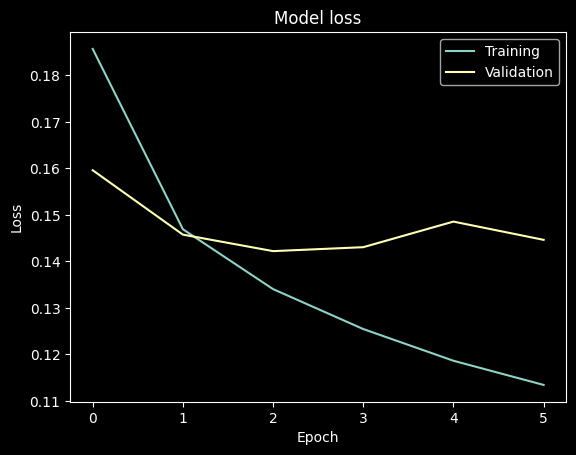

In [31]:
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


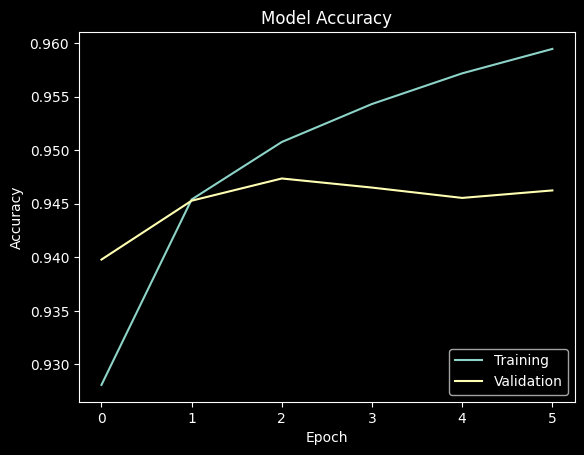

In [32]:
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step


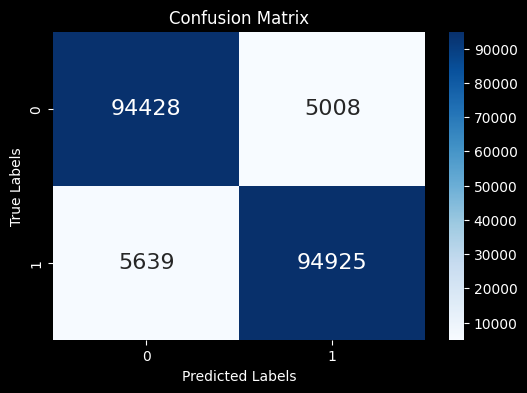

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

max_length = 100
test_seq_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

test_seq_np = np.array(test_seq_padded)

predictions = model.predict(test_seq_np)

predicted_labels = np.round(predictions)
true_labels = np.array(df_test['label'])

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

max_length = 100
test_seq_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

test_seq_np = np.array(test_seq_padded)

predictions = model.predict(test_seq_np)

predicted_labels = np.round(predictions)
true_labels = np.array(df_test['label'])

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

table = [
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1-score", f1]
]

print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step
╒═══════════╤══════════╕
│ Metric    │    Value │
╞═══════════╪══════════╡
│ Accuracy  │ 0.946765 │
├───────────┼──────────┤
│ Precision │ 0.949886 │
├───────────┼──────────┤
│ Recall    │ 0.943926 │
├───────────┼──────────┤
│ F1-score  │ 0.946897 │
╘═══════════╧══════════╛


##END

In [37]:
model.save('Sentiment_Analysis.h5')

In [36]:
import files
!zip -r saved_model.zip 'C:\M'
files.download('saved_model.zip')

ModuleNotFoundError: No module named 'files'

In [38]:
import json
tokenizer_json = tokenizer.to_json()

with open('tokenizer.json', 'w', encoding='utf-8') as f:
    json.dump(tokenizer_json, f, ensure_ascii=False)

In [39]:
import files
files.download('tokenizer.json')

ModuleNotFoundError: No module named 'files'

In [ ]:
model.predict()

In [ ]:
import tensorflow as tf
print(tf.__version__)